In [41]:
import os
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, timedelta
import matplotlib.dates as mdates
import pandas as pd
# import seaborn as sns
import json
import time
from util import (
    load_GaMMA_catalog,
    load_scsn,
    load_Ross2019,
    load_Shelly2020,
    load_Liu2020,
    load_eqnet_catalog,
    filter_catalog,
    calc_detection_performance,
    calc_time_loc_error,
    plot_loc_error,
    timestamp,
    calc_time_mag_error,
)
# sns.set_theme()
import cartopy.crs as ccrs
from sklearn.neighbors import NearestNeighbors
from tqdm import tqdm


In [42]:
dates =[f"2019-07-{x:02d}" for x in range(4, 11)]
start_datetime = datetime.fromisoformat(dates[0])
end_datetime = datetime.fromisoformat(dates[-1])
hours = range(24)
xmin = 0
xmax = 111.2
ymin = xmin
ymax = xmax

if not os.path.exists("figures"):
    os.makedirs("figures")

In [43]:
begin_time = datetime.fromisoformat("2019-07-04T00:00:00")
end_time = datetime.fromisoformat("2019-07-10T00:00:00")
config = {
    "minlatitude": 35.205,
    "maxlatitude": 36.205,
    "minlongitude": -118.004,
    "maxlongitude": -117.004,
    # "minlatitude": 35.47,
    # "maxlatitude": 36.03,
    # "minlongitude": -117.82,
    # "maxlongitude": -117.25,
    "mindepth": 0.0,
    "maxdepth": 30.0,
}

In [44]:
root_dir = lambda x: os.path.join("catalogs", x)

# ##
# gamma_picks = pd.read_csv(root_dir("gamma_paper/gamma_picks.csv"))
# gamma_events = pd.read_csv(root_dir("gamma_paper/gamma_events.csv"))

## 
adloc_gamma_picks = pd.read_csv(root_dir("adloc_gamma_picks.csv"))
adloc_gamma_events = pd.read_csv(root_dir("adloc_gamma_events.csv"))

adloc_plus_picks = pd.read_csv(root_dir("adloc_plus_picks.csv"))
adloc_plus_events = pd.read_csv(root_dir("adloc_plus_events.csv"))

adloc_gamma_plus_picks = pd.read_csv(root_dir("adloc_gamma_plus_picks.csv"))
adloc_gamma_plus_events = pd.read_csv(root_dir("adloc_gamma_plus_events.csv"))

## read stations
# stations = pd.read_csv(root_dir("gamma_paper/gamma_stations.csv"), delimiter="\t")
stations = pd.read_csv(root_dir("stations.csv"))


In [45]:
def filter_events(picks, events, stations, MIN_NEAREST_STATION_RATIO=0.3):

    stations = stations[stations["station_id"].isin(picks["station_id"].unique())]

    neigh = NearestNeighbors(n_neighbors=min(len(stations), 10))
    neigh.fit(stations[["longitude", "latitude"]].values)

    picks = picks.merge(events[["event_index", "longitude", "latitude"]], on="event_index", suffixes=("", "_event"))
    picks = picks.merge(stations[["station_id", "longitude", "latitude"]], on="station_id", suffixes=("", "_station"))

    filtered_events = []
    for i, event in tqdm(events.iterrows(), total=len(events)):
        sid = neigh.kneighbors([[event["longitude"], event["latitude"]]])[1][0]
        picks_ = picks[picks["event_index"] == event["event_index"]]
        # longitude, latitude = picks_[["longitude", "latitude"]].mean().values
        # sid = neigh.kneighbors([[longitude, latitude]])[1][0]
        stations_neigh = stations.iloc[sid]["station_id"].values
        picks_neigh = picks_[picks_["station_id"].isin(stations_neigh)]
        stations_with_picks = picks_neigh["station_id"].unique()
        if len(stations_with_picks) / len(stations_neigh) > MIN_NEAREST_STATION_RATIO:
            filtered_events.append(event)

    print(f"Events before filtering: {len(events)}")
    print(f"Events after filtering: {len(filtered_events)}")
    filtered_events = pd.DataFrame(filtered_events)
    # os.system(f"mv {result_path('gamma_events.csv')} {result_path('gamma_events_raw.csv')}")
    # filtered_events.to_csv(result_path("gamma_events.csv"), index=False)
    return filtered_events

In [46]:
adloc_gamma_events = filter_events(adloc_gamma_picks, adloc_gamma_events, stations)
adloc_plus_events = filter_events(adloc_plus_picks, adloc_plus_events, stations)
adloc_gamma_plus_events = filter_events(adloc_gamma_plus_picks, adloc_gamma_plus_events, stations)


100%|██████████| 26348/26348 [00:32<00:00, 821.33it/s]


Events before filtering: 26348
Events after filtering: 23100


100%|██████████| 19620/19620 [00:23<00:00, 849.50it/s]


Events before filtering: 19620
Events after filtering: 18516


100%|██████████| 26027/26027 [00:30<00:00, 865.82it/s]


Events before filtering: 26027
Events after filtering: 23452


In [13]:
scsc_events = load_scsn()
# shelly_events = load_Shelly2020()
# liu_events = load_Liu2020()

--2024-11-11 14:11:47--  https://raw.githubusercontent.com/SCEDC/SCEDC-catalogs/master/SCSN/2019.catalog
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5159017 (4.9M) [text/plain]
Saving to: ‘2019.catalog’

     0K .......... .......... .......... .......... ..........  0% 4.05M 1s
    50K .......... .......... .......... .......... ..........  1% 6.37M 1s
   100K .......... .......... .......... .......... ..........  2%  429K 4s
   150K .......... .......... .......... .......... ..........  3% 15.3M 3s
   200K .......... .......... .......... .......... ..........  4%  123M 3s
   250K .......... .......... .......... .......... ..........  5%  119M 2s
   300K .......... .......... .......... .......... ..........  6% 32.2M 2s
   350K .......... .........

In [48]:

scsc_events["time"] = pd.to_datetime(scsc_events["time"])
adloc_gamma_events["time"] = pd.to_datetime(adloc_gamma_events["time"])
adloc_plus_events["time"] = pd.to_datetime(adloc_plus_events["time"])
adloc_gamma_plus_events["time"] = pd.to_datetime(adloc_gamma_plus_events["time"])

scsc_events = scsc_events[(scsc_events["time"] >= begin_time) & (scsc_events["time"] <= end_time)]
adloc_gamma_events = adloc_gamma_events[(adloc_gamma_events["time"] >= begin_time) & (adloc_gamma_events["time"] <= end_time)]
adloc_plus_events = adloc_plus_events[(adloc_plus_events["time"] >= begin_time) & (adloc_plus_events["time"] <= end_time)]
adloc_gamma_plus_events = adloc_gamma_plus_events[(adloc_gamma_plus_events["time"] >= begin_time) & (adloc_gamma_plus_events["time"] <= end_time)]

scsc_events = scsc_events[(scsc_events["longitude"] >= config["minlongitude"]) & (scsc_events["longitude"] <= config["maxlongitude"]) & (scsc_events["latitude"] >= config["minlatitude"]) & (scsc_events["latitude"] <= config["maxlatitude"])]
adloc_gamma_events = adloc_gamma_events[(adloc_gamma_events["longitude"] >= config["minlongitude"]) & (adloc_gamma_events["longitude"] <= config["maxlongitude"]) & (adloc_gamma_events["latitude"] >= config["minlatitude"]) & (adloc_gamma_events["latitude"] <= config["maxlatitude"])]
adloc_plus_events = adloc_plus_events[(adloc_plus_events["longitude"] >= config["minlongitude"]) & (adloc_plus_events["longitude"] <= config["maxlongitude"]) & (adloc_plus_events["latitude"] >= config["minlatitude"]) & (adloc_plus_events["latitude"] <= config["maxlatitude"])]
adloc_gamma_plus_events = adloc_gamma_plus_events[(adloc_gamma_plus_events["longitude"] >= config["minlongitude"]) & (adloc_gamma_plus_events["longitude"] <= config["maxlongitude"]) & (adloc_gamma_plus_events["latitude"] >= config["minlatitude"]) & (adloc_gamma_plus_events["latitude"] <= config["maxlatitude"])]


In [49]:
adloc_gamma_picks["phase_time"] = pd.to_datetime(adloc_gamma_picks["phase_time"])
adloc_plus_picks["phase_time"] = pd.to_datetime(adloc_plus_picks["phase_time"])
adloc_gamma_plus_picks["phase_time"] = pd.to_datetime(adloc_gamma_plus_picks["phase_time"])

adloc_gamma_picks = adloc_gamma_picks[adloc_gamma_picks["event_index"].isin(adloc_gamma_events["event_index"])]
adloc_plus_picks = adloc_plus_picks[adloc_plus_picks["event_index"].isin(adloc_plus_events["event_index"])]
adloc_gamma_plus_picks = adloc_gamma_plus_picks[adloc_gamma_plus_picks["event_index"].isin(adloc_gamma_plus_events["event_index"])]


/tmp/ipykernel_3813968/39512689.py:3: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  bins = pd.date_range(begin_time, end_time, freq="3H")


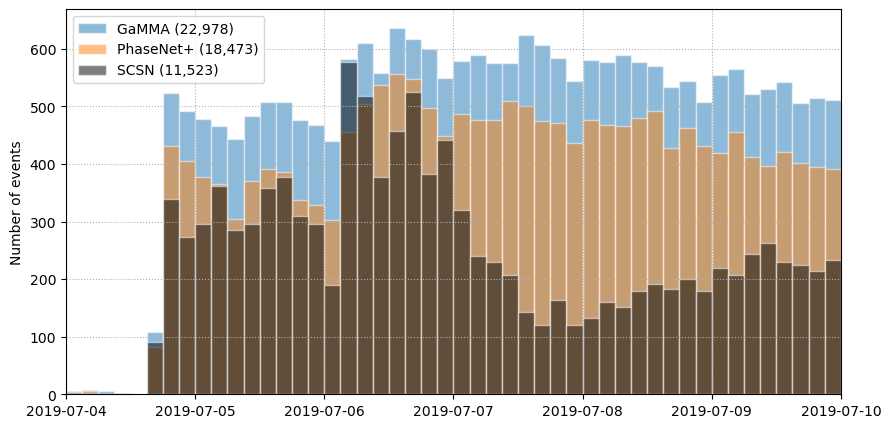

In [50]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5), squeeze=False)

bins = pd.date_range(begin_time, end_time, freq="3H")
ax[0, 0].hist(adloc_gamma_events["time"], bins=bins, edgecolor="white", label=f"GaMMA ({len(adloc_gamma_events):,})", alpha=0.5)
# ax[0, 0].hist(adloc_gamma_plus_events["time"], bins=bins, edgecolor="white", label=f"GaMMA+PhaseNet+ ({len(adloc_gamma_plus_events):,})", alpha=0.5)
ax[0, 0].hist(adloc_plus_events["time"], bins=bins, edgecolor="white", label=f"PhaseNet+ ({len(adloc_plus_events):,})", alpha=0.5)
ax[0, 0].hist(scsc_events["time"], bins=bins, edgecolor="white", label=f"SCSN ({len(scsc_events):,})", alpha=0.5, facecolor="k")

ax[0, 0].legend(loc="upper left")
ax[0, 0].set_xlim([begin_time, end_time])
ax[0, 0].set_ylabel("Number of events")
ax[0, 0].grid(True, linestyle=":", alpha=1.0)

plt.savefig("figures/event_time_histogram.png", dpi=300, bbox_inches="tight")
plt.savefig("figures/event_time_histogram.pdf", dpi=300, bbox_inches="tight")

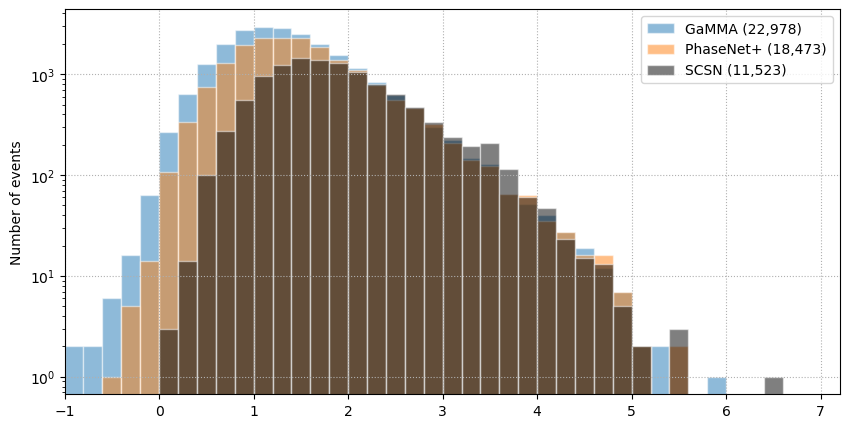

In [56]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5), squeeze=False)

# bins = pd.date_range(begin_time, end_time, freq="3H")
bins = np.arange(-1, 7.2, 0.2)
ax[0, 0].hist(adloc_gamma_events["magnitude"], bins=bins, edgecolor="white", label=f"GaMMA ({len(adloc_gamma_events):,})", alpha=0.5)
# ax[0, 0].hist(adloc_gamma_plus_events["magnitude"], bins=bins, edgecolor="white", label=f"GaMMA+PhaseNet+ ({len(adloc_gamma_plus_events):,})", alpha=0.5)
ax[0, 0].hist(adloc_plus_events["magnitude"]+0.5, bins=bins, edgecolor="white", label=f"PhaseNet+ ({len(adloc_plus_events):,})", alpha=0.5)
ax[0, 0].hist(scsc_events["magnitude"], bins=bins, edgecolor="white", label=f"SCSN ({len(scsc_events):,})", alpha=0.5, facecolor="k")
ax[0, 0].legend(loc="upper right")
ax[0, 0].set_xlim([-1, 7.2])
ax[0, 0].set_ylabel("Number of events")
ax[0, 0].grid(True, linestyle=":", alpha=1.0)
# set y axis to log scale
ax[0, 0].set_yscale("log")

plt.savefig("figures/event_mag_histogram.png", dpi=300, bbox_inches="tight")
plt.savefig("figures/event_mag_histogram.pdf", dpi=300, bbox_inches="tight")

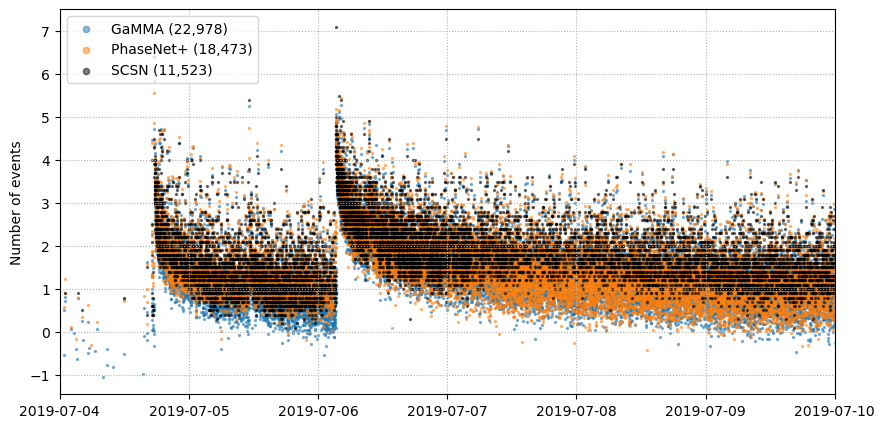

In [57]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5), squeeze=False)

ax[0, 0].scatter(adloc_gamma_events["time"], adloc_gamma_events["magnitude"], s=2, alpha=0.5, rasterized=True)
ax[0, 0].scatter(adloc_plus_events["time"], adloc_plus_events["magnitude"] + 0.5, s=2, alpha=0.5, rasterized=True)
# ax[0, 0].scatter(adloc_gamma_plus_events["time"], adloc_gamma_plus_events["magnitude"], s=2, alpha=0.5, rasterized=True)
ax[0, 0].scatter(scsc_events["time"], scsc_events["magnitude"], s=2, alpha=0.5, color="k", rasterized=True)

ax[0, 0].set_prop_cycle(None)  # Reset the color cycle to start from beginning

ax[0, 0].scatter([], [], s=20, alpha=0.5, label=f"GaMMA ({len(adloc_gamma_events):,})")
ax[0, 0].scatter([], [], s=20, alpha=0.5, label=f"PhaseNet+ ({len(adloc_plus_events):,})")
# ax[0, 0].scatter([], [], s=20, alpha=0.5, label=f"GaMMA+PhaseNet+ ({len(adloc_gamma_plus_events):,})")
ax[0, 0].scatter([], [], s=20, alpha=0.5, label=f"SCSN ({len(scsc_events):,})", color="k")

ax[0, 0].legend(loc="upper left")
ax[0, 0].set_xlim([begin_time, end_time])
ax[0, 0].set_ylabel("Number of events")
ax[0, 0].grid(True, linestyle=":", alpha=1.0)

plt.savefig("figures/event_time_mag.png", dpi=300, bbox_inches="tight")
plt.savefig("figures/event_time_mag.pdf", dpi=300, bbox_inches="tight")

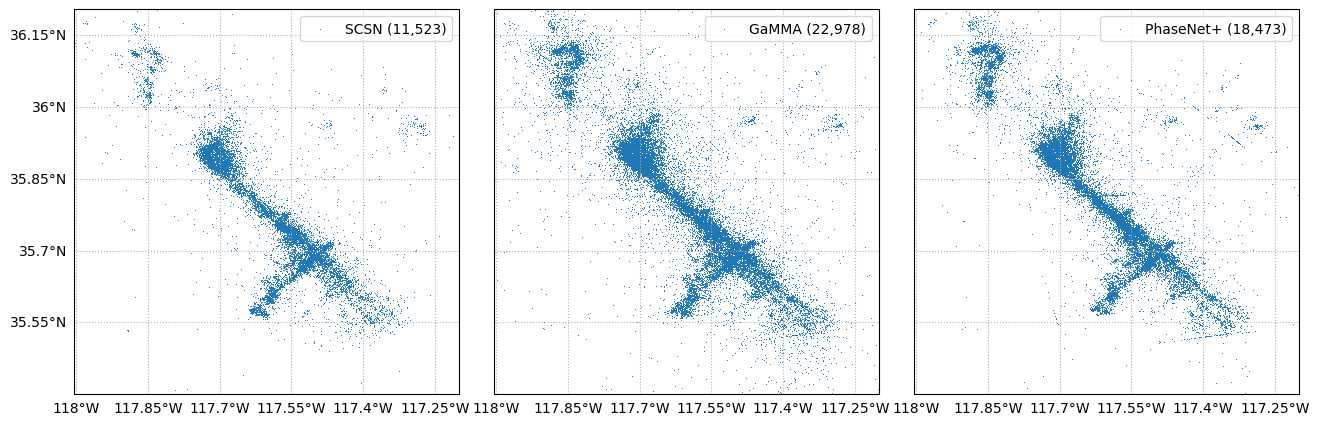

In [58]:
fig, ax = plt.subplots(1, 3, figsize=(16, 5), squeeze=False, subplot_kw={"projection": ccrs.PlateCarree()}, gridspec_kw={"wspace": 0.05, "hspace": 0.01})

# ax[0, 0].scatter(gamma_events["longitude"], gamma_events["latitude"],  s=0.01, transform=ccrs.PlateCarree(), label=f"GaMMA ({len(gamma_events)})")
# ax[0, 0].scatter(adloc_events["longitude"], adloc_events["latitude"], s=0.01, transform=ccrs.PlateCarree(), label=f"AdLoc ({len(adloc_events)})")

s = 0.5
xmin = config["minlongitude"]
xmax = config["maxlongitude"]
ymin = config["minlatitude"]
ymax = config["maxlatitude"]

xmax = -117.2
ymin= 35.4

ax[0, 0].scatter(scsc_events["longitude"], scsc_events["latitude"], s=s, linewidth=0.,
                 rasterized=True,
                 transform=ccrs.PlateCarree(), label=f"SCSN ({len(scsc_events):,})")
ax[0, 0].set_xlim([xmin, xmax])
ax[0, 0].set_ylim([ymin, ymax])
ax[0, 0].legend(loc="upper right")
gl = ax[0, 0].gridlines(draw_labels=True, linestyle=':')
gl.top_labels = False
gl.right_labels = False

ax[0, 1].scatter(adloc_gamma_events["longitude"], adloc_gamma_events["latitude"], s=s, linewidth=0.,
                 rasterized=True,
                 transform=ccrs.PlateCarree(), label=f"GaMMA ({len(adloc_gamma_events):,})")
ax[0, 1].set_xlim([xmin, xmax])
ax[0, 1].set_ylim([ymin, ymax])
ax[0, 1].legend(loc="upper right")
gl = ax[0, 1].gridlines(draw_labels=True, linestyle=':')
gl.top_labels = False
gl.right_labels = False
gl.left_labels = False


# ax[0, 2].scatter(liu_events["longitude"], liu_events["latitude"], s=s, linewidth=0.,
#                     rasterized=True,
#                     transform=ccrs.PlateCarree(), label=f"Liu 2020 ({len(liu_events):,})")
# ax[0, 2].set_xlim([xmin, xmax])
# ax[0, 2].set_ylim([ymin, ymax])
# ax[0, 2].legend(loc="upper left")
# gl = ax[0, 2].gridlines(draw_labels=True, linestyle=':')
# gl.top_labels = False
# gl.right_labels = False
# gl.left_labels = False

ax[0, 2].scatter(adloc_plus_events["longitude"], adloc_plus_events["latitude"], s=s, linewidth=0.,
                 rasterized=True,
                 transform=ccrs.PlateCarree(), label=f"PhaseNet+ ({len(adloc_plus_events):,})")
ax[0, 2].set_xlim([xmin, xmax])
ax[0, 2].set_ylim([ymin, ymax])
ax[0, 2].legend(loc="upper right")
gl = ax[0, 2].gridlines(draw_labels=True, linestyle=':')
gl.top_labels = False
gl.right_labels = False
gl.left_labels = False

plt.savefig("figures/event_map.png", dpi=300, bbox_inches="tight")
plt.savefig("figures/event_map.pdf", dpi=300, bbox_inches="tight")



In [19]:
## read catalaogs
# t_gamma, xyz_gamma, mag_gamma, catalog_gamma = filter_catalog(load_GaMMA_catalog(root_dir("catalog_gamma.csv")), start_datetime, end_datetime, xmin, xmax, ymin, ymax)
# catalog_gamma["time"] = catalog_gamma["time"].apply(lambda x: datetime.fromisoformat(x))
# t_eqnet, xyz_eqnet, mag_eqnet, catalog_eqnet = filter_catalog(load_eqnet_catalog(root_dir("2019-07-04-2019-07-08-threshold050.txt")), start_datetime, end_datetime, xmin, xmax, ymin, ymax)
t_scsn, xyz_scsn, mag_scsn, catalog_scsn = filter_catalog(load_scsn(), start_datetime, end_datetime, xmin, xmax, ymin, ymax)
# t_ross2019, xyz_ross2019, mag_ross2019, catalog_ross2019 = filter_catalog(load_Ross2019(), start_datetime, end_datetime, xmin, xmax, ymin, ymax)
# t_liu2020, xyz_liu2020, mag_liu2020, catalog_liu2020 = filter_catalog(load_Liu2020(), start_datetime, end_datetime, xmin, xmax, ymin, ymax)
t_shelly2020, xyz_shelly2020, mag_shelly2020, catalog_shelly2020 = filter_catalog(load_Shelly2020(), start_datetime, end_datetime, xmin, xmax, ymin, ymax)

Filtered catalog 2019-07-04 00:00:00-2019-07-10 00:00:00: 0 events
Filtered catalog 2019-07-04 00:00:00-2019-07-10 00:00:00: 0 events


In [20]:
label_model="GaMMA"
label_baseline="SCSN"
catalog_model = catalog_gamma
catalog_baseline = catalog_scsn
marker_size = 0.2
bins = min(len(catalog_baseline["time"])//50 + 10, 50)

NameError: name 'catalog_gamma' is not defined

In [ ]:
plt.figure(figsize=(10, 6))
plt.subplot(2, 2, 1)
plt.hist(mag_gamma, bins=50, range=[np.min([np.min(mag_gamma), np.min(mag_scsn)]), np.max([np.max(mag_gamma), np.max(mag_scsn)])], label=f"GaMMA\n:{len(mag_gamma)}")
plt.hist(mag_scsn, bins=50, range=[np.min([np.min(mag_gamma), np.min(mag_scsn)]), np.max([np.max(mag_gamma), np.max(mag_scsn)])], alpha=0.5, label=f"SCSN: {len(mag_scsn)}")
plt.gca().set_yscale('log')
ylim = plt.ylim()
plt.legend()
plt.ylabel("Frequency")
plt.subplot(2, 2, 2)
plt.hist(mag_ross2019, bins=50, range=[np.min([np.min(mag_gamma), np.min(mag_scsn)]), np.max([np.max(mag_gamma), np.max(mag_scsn)])], label=f"Ross et al. (2019)\n:{len(mag_ross2019)}")
plt.hist(mag_scsn, bins=50, range=[np.min([np.min(mag_gamma), np.min(mag_scsn)]), np.max([np.max(mag_gamma), np.max(mag_scsn)])], alpha=0.5, label=f"SCSN: {len(mag_scsn)}")
plt.gca().set_yscale('log')
plt.ylim(ylim)
plt.legend()
plt.subplot(2, 2, 3)
# plt.hist(mag_liu2020, bins=50, range=[np.min([np.min(mag_gamma), np.min(mag_scsn)]), np.max([np.max(mag_gamma), np.max(mag_scsn)])], label=f"Liu et al. (2020)\n:{len(mag_liu2020)}")
plt.hist(mag_scsn, bins=50, range=[np.min([np.min(mag_gamma), np.min(mag_scsn)]), np.max([np.max(mag_gamma), np.max(mag_scsn)])], alpha=0.5, label=f"SCSN: {len(mag_scsn)}")
plt.gca().set_yscale('log')
plt.ylim(ylim)
plt.legend()
plt.xlabel("Magnitude")
plt.ylabel("Frequency")
plt.subplot(2, 2, 4)
plt.hist(mag_shelly2020, bins=50, range=[np.min([np.min(mag_gamma), np.min(mag_scsn)]), np.max([np.max(mag_gamma), np.max(mag_scsn)])], label=f"Shelly (2020)\n:{len(mag_shelly2020)}")
plt.hist(mag_scsn, bins=50, range=[np.min([np.min(mag_gamma), np.min(mag_scsn)]), np.max([np.max(mag_gamma), np.max(mag_scsn)])], alpha=0.5,  label=f"SCSN: {len(mag_scsn)}")
plt.gca().set_yscale('log')
plt.ylim(ylim)
plt.legend()
plt.xlabel("Magnitude")
plt.tight_layout()
plt.savefig("figures/compare_magnitude.png", bbox_inches="tight", dpi=300)
plt.savefig("figures/compare_magnitude.pdf", bbox_inches="tight")

In [ ]:
## GaMMA
marker_size = 0.4
alpha = 0.4
plot_depth = True

## EQNet
# marker_size = 0.8
# alpha = 0.4
# plot_depth = False

fig = plt.figure(figsize=plt.rcParams["figure.figsize"]*np.array([1.8,1.3]))
box = dict(boxstyle='round', facecolor='white', alpha=1)
text_loc = [0.05, 0.92]
if plot_depth:
    grd = fig.add_gridspec(ncols=2, nrows=2, width_ratios=[1.5, 1], height_ratios=[1,1])
    fig.add_subplot(grd[:, 0])
plt.scatter(catalog_baseline["longitude"], catalog_baseline["latitude"], s=marker_size, c="C1", linewidths=marker_size, alpha=0.5, rasterized=True)
plt.scatter(catalog_model["longitude"], catalog_model["latitude"], s=marker_size, c="C0", linewidths=marker_size, alpha=alpha, rasterized=True)
plt.plot(stations["longitude"], stations["latitude"], 'k^', markersize=5, alpha=1.0, label="Stations")
plt.axis("scaled")
plt.xlim(np.array(config["xlim_degree"]))#+np.array([0.2,-0.27]))
plt.ylim(np.array(config["ylim_degree"]))#+np.array([0.2,-0.27]))
plt.ylabel("Latitude")
plt.xlabel("Longitude")
plt.gca().set_prop_cycle(None)
plt.plot(config["xlim_degree"][0]-10, config["ylim_degree"][0]-10, '.', c="C0", markersize=10, label=f"{label_model}: {len(catalog_model['time'])}")
plt.plot(config["xlim_degree"][0]-10, config["ylim_degree"][0]-10, '.', c="C1", markersize=10, label=f"{label_baseline}: {len(catalog_baseline['time'])}")
plt.legend(loc="lower right")
if plot_depth:
    plt.text(text_loc[0], text_loc[1]+0.03, '(i)', horizontalalignment='left', verticalalignment="top", 
            transform=plt.gca().transAxes, fontweight="normal", bbox=box)

if plot_depth:
    fig.add_subplot(grd[0, 1])
    plt.scatter(catalog_baseline["longitude"], catalog_baseline["depth(m)"]/1e3, s=marker_size, c="C1", linewidths=marker_size, alpha=0.5, rasterized=True)
    plt.scatter(catalog_model["longitude"], catalog_model["depth(m)"]/1e3, s=marker_size, c="C0", linewidths=marker_size, alpha=alpha, rasterized=True)
    # plt.axis("scaled")
    plt.xlim(np.array(config["xlim_degree"]))#+np.array([0.2,-0.27]))
    plt.ylim([0,21])
    # plt.ylim(bottom=0, top=41)
    plt.gca().invert_yaxis()
    plt.xlabel("Longitude")
    plt.ylabel("Depth (km)")
    plt.gca().set_prop_cycle(None)
    plt.plot(config["xlim_degree"][0]-10, 31, '.', c="C0", markersize=10, label=f"{label_model}")
    plt.plot(31, 31, '.', c="C1", markersize=10, label=f"{label_baseline}")
    plt.legend(loc="lower right")
    plt.text(text_loc[0], text_loc[1], '(ii)', horizontalalignment='left', verticalalignment="top", 
            transform=plt.gca().transAxes, fontweight="normal", bbox=box)

    fig.add_subplot(grd[1, 1])
    plt.scatter(catalog_baseline["latitude"], catalog_baseline["depth(m)"]/1e3, s=marker_size, c="C1", linewidths=marker_size, alpha=0.5, rasterized=True)
    plt.scatter(catalog_model["latitude"], catalog_model["depth(m)"]/1e3, s=marker_size, c="C0", linewidths=marker_size, alpha=alpha, rasterized=True)
    # plt.axis("scaled")
    plt.xlim(np.array(config["ylim_degree"]))#+np.array([0.2,-0.27]))
    plt.ylim([0,21])
    # plt.ylim(bottom=0, top=41)
    plt.gca().invert_yaxis()
    plt.xlabel("Latitude")
    plt.ylabel("Depth (km)")
    plt.gca().set_prop_cycle(None)
    plt.plot(config["ylim_degree"][0]-10, 31, '.', c="C0", markersize=10, label=f"{label_model}")
    plt.plot(31, 31, '.', c="C1", markersize=10, label=f"{label_baseline}")
    plt.legend(loc="lower left")
    plt.tight_layout()
    plt.text(text_loc[0], text_loc[1], '(iii)', horizontalalignment='left', verticalalignment="top", 
            transform=plt.gca().transAxes, fontweight="normal", bbox=box)

plt.savefig(root_dir("figures/earthquake_location.png"), bbox_inches="tight", dpi=300)
plt.savefig(root_dir("figures/earthquake_location.pdf"), bbox_inches="tight", dpi=300)
plt.show()

In [ ]:
plt.figure()
plt.hist(np.array(catalog_model["time"]).astype("datetime64[ms]"), range=(config["starttime"], config["endtime"]), bins=bins, label=f"{label_model}: {len(catalog_model['time'])}")
plt.hist(np.array(catalog_baseline["time"]).astype("datetime64[ms]"), range=(config["starttime"], config["endtime"]), bins=bins, label=f"{label_baseline}: {len(catalog_baseline['time'])}")
plt.ylabel("Frequency")
plt.xlabel("Date")
# plt.yscale("log")
plt.gca().autoscale(enable=True, axis='x', tight=True)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
plt.gcf().autofmt_xdate()
plt.legend(loc="upper right")
plt.savefig(root_dir("figures/earthquake_number.png"), bbox_inches="tight", dpi=300)
plt.savefig(root_dir("figures/earthquake_number.pdf"), bbox_inches="tight")
plt.show()

In [ ]:
plt.figure()
plt.hist(np.array(catalog_shelly2020["time"]).astype("datetime64[ms]"), range=(config["starttime"], config["endtime"]), bins=bins, label=f"Shelly (2020): {len(catalog_shelly2020['time'])}")
plt.hist(np.array(catalog_baseline["time"]).astype("datetime64[ms]"), range=(config["starttime"], config["endtime"]), bins=bins, alpha=0.6, label=f"{label_baseline}: {len(catalog_baseline['time'])}")
plt.ylabel("Frequency")
plt.xlabel("Date")
# plt.yscale("log")
plt.gca().autoscale(enable=True, axis='x', tight=True)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
plt.gcf().autofmt_xdate()
plt.legend()
plt.savefig(root_dir("figures/earthquake_number_shelly.png"), bbox_inches="tight", dpi=300)
plt.savefig(root_dir("figures/earthquake_number_shelly.pdf"), bbox_inches="tight")
plt.show()

In [ ]:
plt.figure()
plt.hist(np.array(catalog_liu2020["time"]).astype("datetime64[ms]"), range=(config["starttime"], config["endtime"]), bins=bins, label=f"Liu et al. (2020): {len(catalog_liu2020['time'])}")
plt.hist(np.array(catalog_baseline["time"]).astype("datetime64[ms]"), range=(config["starttime"], config["endtime"]), bins=bins, alpha=0.6, label=f"{label_baseline}: {len(catalog_baseline['time'])}")
plt.ylabel("Frequency")
plt.xlabel("Date")
# plt.yscale("log")
plt.gca().autoscale(enable=True, axis='x', tight=True)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
plt.gcf().autofmt_xdate()
plt.legend()
plt.savefig(root_dir("figures/earthquake_number_liu.png"), bbox_inches="tight", dpi=300)
plt.savefig(root_dir("figures/earthquake_number_liu.pdf"), bbox_inches="tight")
plt.show()

In [ ]:
marker_size = 0.5
plt.figure()
plt.scatter(np.array(catalog_model["time"]).astype("datetime64[ms]"), catalog_model["magnitude"], s=marker_size, linewidths=marker_size, alpha=1.0, rasterized=True)
plt.scatter(np.array(catalog_baseline["time"]).astype("datetime64[ms]"), catalog_baseline["magnitude"], s=marker_size, linewidths=marker_size, alpha=1.0, rasterized=True)
plt.xlim(datetime.fromisoformat(config["starttime"]), datetime.fromisoformat(config["endtime"]))
# plt.ylim(top=events["magnitude"].max())
ylim = plt.ylim(bottom=-1)
xlim = plt.xlim()
plt.ylabel("Magnitude")
plt.xlabel("Date")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
plt.gcf().autofmt_xdate()
plt.gca().set_prop_cycle(None)
plt.plot(datetime.fromisoformat(config["starttime"]), -10, '.', markersize=15, alpha=1.0, label=f"{label_model}: {len(catalog_model['magnitude'])}")
plt.plot(datetime.fromisoformat(config["starttime"]), -10, '.', markersize=15, alpha=1.0, label=f"{label_baseline}: {len(catalog_baseline['magnitude'])}")
plt.legend()
plt.xlim(xlim)
plt.ylim(ylim)
# plt.grid()
plt.savefig(root_dir("figures/earthquake_magnitude_time.png"), bbox_inches="tight", dpi=300)
plt.savefig(root_dir("figures/earthquake_magnitude_time.pdf"), bbox_inches="tight", dpi=300)
plt.show();

In [ ]:
marker_size = 0.2

fig = plt.figure(figsize=plt.rcParams["figure.figsize"]*np.array([0.8,1.1]))
box = dict(boxstyle='round', facecolor='white', alpha=1)
text_loc = [0.05, 0.90]
plt.subplot(311)
plt.scatter(np.array(catalog_model["time"]).astype("datetime64[ms]"), catalog_model["sigma_time"], s=marker_size, linewidths=marker_size, label="Traveltime", rasterized=True)
# plt.ylim([0, 3])
plt.ylabel(r"$\sigma_{11}$ (s)")
plt.legend(loc="upper right", fontsize="small")
plt.text(text_loc[0], text_loc[1], '(i)', horizontalalignment='left', verticalalignment="top", 
         transform=plt.gca().transAxes, fontweight="normal", bbox=box)
plt.xlim(datetime.fromisoformat(config["starttime"]), datetime.fromisoformat(config["endtime"]))

plt.subplot(312)
plt.scatter(np.array(catalog_model["time"]).astype("datetime64[ms]"), catalog_model["sigma_amp"], s=marker_size, linewidths=marker_size, label="Amplitude", rasterized=True)
# plt.ylim([0, 1])
plt.ylabel(r"$\sigma_{22}$ ($\log_{10}$ m/s)")
plt.legend(loc="upper right", fontsize="small")
plt.text(text_loc[0], text_loc[1], '(ii)', horizontalalignment='left', verticalalignment="top", 
         transform=plt.gca().transAxes, fontweight="normal", bbox=box)
plt.xlim(datetime.fromisoformat(config["starttime"]), datetime.fromisoformat(config["endtime"]))

plt.subplot(313)
plt.scatter(np.array(catalog_model["time"]).astype("datetime64[ms]"), catalog_model["cov_time_amp"], s=marker_size, linewidths=marker_size, label="Traveltime vs. Amplitude", rasterized=True)
plt.ylabel(r"$\Sigma_{12}$")
# plt.ylim([-0.5, 0.5])
plt.legend(loc="upper right", fontsize="small")
plt.text(text_loc[0], text_loc[1], '(iii)', horizontalalignment='left', verticalalignment="top", 
         transform=plt.gca().transAxes, fontweight="normal", bbox=box)
plt.xlim(datetime.fromisoformat(config["starttime"]), datetime.fromisoformat(config["endtime"]))

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
plt.gcf().autofmt_xdate()
# plt.suptitle(r"Covariance Matrix ($\Sigma$) Coefficients")
plt.tight_layout()
plt.gcf().align_labels()
plt.savefig(root_dir("figures/covariance.png"), bbox_inches="tight", dpi=300)
plt.savefig(root_dir("figures/covariance.pdf"), bbox_inches="tight", dpi=300)
plt.show();

In [13]:
## plot error distribution
t_model = t_gamma
xyz_model = xyz_gamma
t_baseline = t_scsn
xyz_baseline = xyz_scsn
mag_model = mag_gamma
mag_baseline = mag_scsn

time_threshold = 5
err_time, err_xyz, err_xy, err_z, err_loc, t = calc_time_loc_error(t_model, xyz_model, t_baseline, xyz_baseline, time_threshold)

In [ ]:
x = err_xyz[:,0]
y = err_xyz[:,1]
z = err_xyz[:,2]

# definitions for the axes
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
spacing = 0.01

rect_scatter = [left, bottom, width, height]
rect_colorbar = [left, bottom - 0.13 - spacing, width, 0.05]
rect_histx = [left, bottom + height + spacing, width, 0.2]
rect_histy = [left + width + spacing, bottom, 0.2, height]

# start with a rectangular Figure
plt.figure(figsize=(6, 6))

ax_scatter = plt.axes(rect_scatter)
ax_colorbar = plt.axes(rect_colorbar)

# ax_scatter.tick_params(direction='in', top=True, right=True)
ax_histx = plt.axes(rect_histx)
ax_histx.tick_params(direction='in', labelbottom=False)
ax_histy = plt.axes(rect_histy)
ax_histy.tick_params(direction='in', labelleft=False)

# the scatter plot:
sc = ax_scatter.scatter(x, y, s=0.5, c=t, cmap="jet", alpha=0.3, rasterized=True)
ax_scatter.set_xlabel("$\Delta$x (km)")
ax_scatter.set_ylabel("$\Delta$y (km)")

cbar = plt.colorbar(sc, cax=ax_colorbar, orientation="horizontal", ticks=[t[0],  t[-1]])
print([str(start_datetime), str(end_datetime)])
cbar.ax.set_xticklabels([dates[0], dates[-1]]) 

# now determine nice limits by hand:
binwidth = 0.5
lim = 11
ax_scatter.set_xlim((-lim, lim))
ax_scatter.set_ylim((-lim, lim))

bins = np.arange(-lim, lim + binwidth, binwidth)
ax_histx.hist(x, bins=bins)
ax_histy.hist(y, bins=bins, orientation='horizontal')

ax_histx.set_xlim(ax_scatter.get_xlim())
ax_histy.set_ylim(ax_scatter.get_ylim())
ax_histx.set_ylabel("Frequency")
ax_histy.set_xlabel("Frequency")

plt.savefig(f"figures/error-xy-{dates[0]}-{dates[-1]}.png", bbox_inches="tight", dpi=300)
plt.savefig(f"figures/error-xy-{dates[0]}-{dates[-1]}.pdf", bbox_inches="tight", dpi=300)


In [ ]:
bins = np.arange(-lim, lim + binwidth, binwidth)
fig = plt.figure(figsize=plt.rcParams["figure.figsize"]*np.array([1.0,1.3]))
plt.subplot(211)
plt.hist(x, bins=bins)
plt.ylabel("Frequency")
plt.xlim((-lim, lim))
plt.gca().set_xlabel([])
plt.xlabel("$\Delta$x (km)")

plt.subplot(212)
plt.hist(y, bins=bins)
plt.xlim((-lim, lim))
plt.ylabel("Frequency")
plt.xlabel("$\Delta$y (km)")

plt.tight_layout()
# plt.savefig(f"figures/error-xy-{dates[0]}-{dates[-1]}.png", bbox_inches="tight", dpi=300)
# plt.savefig(f"figures/error-xy-{dates[0]}-{dates[-1]}.pdf", bbox_inches="tight", dpi=300)

In [ ]:
bins = np.arange(-15, 20 + binwidth, 1.5*binwidth)
fig = plt.figure(figsize=plt.rcParams["figure.figsize"]*np.array([1.0,1.3]))
plt.subplot(211)
plt.hist(z, bins=bins)
# plt.hist(z, bins=51, range=(-15, 20))
# plt.xlim([0, 20])
plt.ylabel("Frequency")
plt.xlabel("$\Delta$z (km)")
plt.savefig(f"figures/error-z-{dates[0]}-{dates[-1]}.png", bbox_inches="tight", dpi=300)
plt.savefig(f"figures/error-z-{dates[0]}-{dates[-1]}.pdf", bbox_inches="tight", dpi=300)

In [ ]:
# plt.figure()
# bins = np.arange(-3, 3 + 0.15, 0.15)
fig = plt.figure(figsize=plt.rcParams["figure.figsize"]*np.array([1.0,0.8]))
# plt.subplot(211)
plt.hist(err_time, bins=51, range=(-3, 3))
plt.xlim([-3, 3])
plt.ylabel("Frequency")
plt.xlabel("$\Delta$t (s)")
plt.savefig(f"figures/error-t-{dates[0]}-{dates[-1]}.png", bbox_inches="tight", dpi=300)
plt.savefig(f"figures/error-t-{dates[0]}-{dates[-1]}.pdf", bbox_inches="tight", dpi=300)

In [18]:
err_time, err_mag, t, mag = calc_time_mag_error(t_model, mag_model, t_baseline, mag_baseline, time_threshold)

In [ ]:
x = mag
y = err_mag

# definitions for the axes
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
spacing = 0.01

rect_scatter = [left, bottom, width, height]
rect_histy = [left + width + spacing, bottom, 0.2, height]

# start with a rectangular Figure
plt.figure(figsize=(6, 4))

ax_scatter = plt.axes(rect_scatter)
# ax_colorbar = plt.axes(rect_colorbar)

# ax_scatter.tick_params(direction='in', top=True, right=True)
ax_histy = plt.axes(rect_histy)
ax_histy.tick_params(direction='in', labelleft=False)

# the scatter plot:
sc = ax_scatter.scatter(x, y, s=2, linewidths=1, alpha=0.3, rasterized=True)
ax_scatter.set_xlabel("Magnitude (SCSN)")
ax_scatter.set_ylabel("$\Delta$m")

# now determine nice limits by hand:
binwidth = 0.1
lim = 2
ax_scatter.set_ylim((-lim, lim))

bins = np.arange(-lim, lim + binwidth, binwidth)
ax_histy.hist(y, bins=bins, orientation='horizontal')

ax_histy.set_ylim(ax_scatter.get_ylim())
ax_histy.set_xlabel("Frequency")

plt.savefig(f"figures/error-mag-{dates[0]}-{dates[-1]}.png", bbox_inches="tight", dpi=300)
plt.savefig(f"figures/error-mag-{dates[0]}-{dates[-1]}.pdf", bbox_inches="tight", dpi=300)


In [ ]:
idx = (np.abs(err_time) < 3)
print("Mean", np.mean(err_time))
print("STD", np.std(err_time))
print("MAE", np.mean(np.abs(err_time)))

In [ ]:
idx = (np.abs(err_xyz[:,0]) < 10) & (np.abs(err_xyz[:,1]) < 10) & (np.abs(err_xyz[:,2]) < 20)
print("Mean", np.mean(err_xyz[idx,0]), np.mean(err_xyz[idx,1]), np.mean(err_xyz[idx,2]))
print("STD", np.std(err_xyz[idx,0]), np.std(err_xyz[idx,1]), np.std(err_xyz[idx,2]))
print("MAE", np.mean(np.abs(err_xyz[idx,0])), np.mean(np.abs(err_xyz[idx,1])), np.mean(np.abs(err_xyz[idx,2])))

In [ ]:
idx = (np.abs(err_mag) < 2)
print("Mean", np.mean(err_mag))
print("STD", np.std(err_mag))
print("MAE", np.mean(np.abs(err_mag)))

In [ ]:
# %% 
# compare with other catalog
time_threshold = 5
fp = open(f"performance-{dates[0]}-{dates[-1]}.txt", "w")
recall, precision, f1 = calc_detection_performance(t_model, t_scsn, time_threshold)
print(f"Pred vs. SCSN : recall={recall:.3f}, precision={precision:.3f}, f1={f1:.3f}")
fp.write(f"Pred vs. SCSN : {len(t_model)}, {len(t_scsn)}\n")
fp.write(f"Pred vs. SCSN : recall={recall:.3f}, precision={precision:.3f}, f1={f1:.3f}\n")
recall, precision, f1 = calc_detection_performance(t_model, t_shelly2020, time_threshold)
print(f"Pred vs. Shelly (2020) : recall={recall:.3f}, precision={precision:.3f}, f1={f1:.3f}")
fp.write(f"Pred vs. Shelly (2020) : {len(t_model)}, {len(t_shelly2020)}\n")
fp.write(f"Pred vs. Shelly (2020) : recall={recall:.3f}, precision={precision:.3f}, f1={f1:.3f}\n")
recall, precision, f1 = calc_detection_performance(t_model, t_liu2020, time_threshold)
print(f"Pred vs. Ming (2020) : recall={recall:.3f}, precision={precision:.3f}, f1={f1:.3f}")
fp.write(f"Pred vs. Ming (2020) : {len(t_model)}, {len(t_liu2020)}\n")
fp.write(f"Pred vs. Ming (2020) : recall={recall:.3f}, precision={precision:.3f}, f1={f1:.3f}\n")
recall, precision, f1 = calc_detection_performance(t_model, t_ross2019, time_threshold)
print(f"Pred vs. Zachary (2019) : recall={recall:.3f}, precision={precision:.3f}, f1={f1:.3f}")
fp.write(f"Pred vs. Zachary (2019) : {len(t_model)}, {len(t_ross2019)}\n")
fp.write(f"Pred vs. Zachary (2019) : recall={recall:.3f}, precision={precision:.3f}, f1={f1:.3f}\n")
fp.write(f"=======================================================\n")

In [ ]:
print(f"P-picks: {len(picks[(picks['type']=='p')])}")
print(f"S-picks: {len(picks[(picks['type']=='s')])}")
print(f"Associated P-picks: {len(picks[(picks['type']=='p') & (picks['event_idx']!=-1)])}")
print(f"Associated S-picks: {len(picks[(picks['type']=='s') & (picks['event_idx']!=-1)])}")
print(f"Unassociated P-picks: {len(picks[(picks['type']=='p')]) - len(picks[(picks['type']=='p') & (picks['event_idx']!=-1)])}")
print(f"Unassociated S-picks: {len(picks[(picks['type']=='s')]) - len(picks[(picks['type']=='s') & (picks['event_idx']!=-1)])}")

In [25]:
starttime = datetime.fromisoformat("2019-07-07T23:59:58")
endtime = datetime.fromisoformat("2019-07-08T00:06:02")

selected_picks = picks[ (picks["time"] > starttime) & (picks["time"] < endtime) ]
selected_picks_full = pd.merge(left=selected_picks, right=stations, left_on="id", right_on="station", how="left")

In [26]:
selected_gamma = catalog_gamma[ (catalog_gamma["time"] > starttime) & (catalog_gamma["time"] < endtime) ]
selected_scsn = catalog_scsn[ (catalog_scsn["time"] > starttime) & (catalog_scsn["time"] < endtime) ]
selected_ross2019 = catalog_ross2019[ (catalog_ross2019["time"] > starttime) & (catalog_ross2019["time"] < endtime) ]

In [ ]:
# plt.figure(figsize=(12, 6))
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(12, 6))

color = {}
selected_gamma = selected_gamma.sort_values(by="time")
for i, x in enumerate(selected_gamma["event_idx"]):
    color[x] = f"C{i}"
for i, x in enumerate(selected_picks_full["event_idx"]):
    if x not in color:
        color[x] = "k"

# plt.subplot(2, 1, 1)
ax[0].scatter(selected_picks_full["time"], selected_picks_full["latitude"], s=8, c=[color[x] for x in selected_picks_full["event_idx"]], linewidths=1, alpha=1.0)
ax[0].scatter(selected_gamma["time"], selected_gamma["latitude"], s=150, c=[color[x] for x in selected_gamma["event_idx"]], marker="+", linewidths=4, alpha=1.0, label=f"GaMMA: {len(selected_gamma['time'])}")
ax[0].scatter(selected_ross2019["time"], selected_ross2019["latitude"], s=120, edgecolors="k", facecolors="none", marker="o", linewidths=1, alpha=1.0, label=f"Ross et al. (2019): {len(selected_ross2019['time'])}")
ax[0].scatter(selected_scsn["time"], selected_scsn["latitude"], s=120, edgecolors="b", facecolors="none", marker="o", linewidths=2,  alpha=1.0, label=f"SCSN: {len(selected_scsn['time'])}")
ax[0].autoscale(enable=True, axis='x', tight=True)
# plt.gca().set_xticklabels([])
ax[0].set_ylabel("Latitude")
ax[0].legend(bbox_to_anchor=(0.35, 0), loc='lower left', ncol=1)
# plt.subplot(2, 1, 2)
ax[1].scatter(selected_picks_full["time"], selected_picks_full["longitude"], s=8, c=[color[x] for x in selected_picks_full["event_idx"]], linewidths=1, alpha=1.0)
ax[1].scatter(selected_gamma["time"], selected_gamma["longitude"], s=120, c=[color[x] for x in selected_gamma["event_idx"]], marker="+", linewidths=3, alpha=1.0, label=f"GaMMA:{len(selected_gamma['time'])}")
ax[1].scatter(selected_ross2019["time"], selected_ross2019["longitude"], s=120, edgecolors="k", facecolors="none", marker="o", linewidths=1, alpha=1.0, label=f"Ross et al. (2019):{len(selected_ross2019['time'])}")
ax[1].scatter(selected_scsn["time"], selected_scsn["longitude"], s=120, edgecolors="b", facecolors="none", marker="o", linewidths=2, alpha=1.0, label=f"SCSN: {len(selected_scsn['time'])}")
ax[1].set_ylabel("Longitude")
ax[1].autoscale(enable=True, axis='x', tight=True)
ax[1].xaxis.set_major_formatter(mdates.DateFormatter('%m-%dT%H:%M'))
fig.autofmt_xdate()
fig.tight_layout()
# plt.legend()

fig.savefig("figures/example.png", bbox_inches="tight", dpi=300)
fig.savefig("figures/example.pdf", bbox_inches="tight")

In [28]:
t_model = selected_gamma["time"].to_numpy().astype(np.float64)/1e9
t_baseline = selected_ross2019["time"].to_numpy().astype(np.float64)/1e9
diff = (t_model[:, np.newaxis] - t_baseline[np.newaxis, :])

In [29]:
new_events = selected_gamma.iloc[~np.any(np.abs(diff) < 4, axis=1)]


In [30]:
import obspy
from obspy.clients.fdsn import Client
from collections import defaultdict

In [31]:
stations = Client(config["client"]).get_stations(
    network=",".join(config["networks"]),
    station="*",
    starttime=config["starttime"],
    endtime=config["endtime"],
    minlongitude=config["xlim_degree"][0],
    maxlongitude=config["xlim_degree"][1],
    minlatitude=config["ylim_degree"][0],
    maxlatitude=config["ylim_degree"][1],
    channel=config["channels"],
    # channel="HNZ",
    level="response",
)  # ,

In [32]:
exclude_stations = ["LRL", "SLA", "Q0072"]
# exclude_stations = ["Q0072"]

In [33]:
station_locs = defaultdict(dict)
for network in stations:
    for station in network:
        for chn in station:
            if station.code in exclude_stations:
                continue
            sid = f"{network.code}.{station.code}.{chn.location_code}.{chn.code[:-1]}"
            if sid in station_locs:
                station_locs[sid]["component"] += f",{chn.code[-1]}"
                station_locs[sid]["response"] += f",{chn.response.instrument_sensitivity.value:.2f}"
            else:
                component = f"{chn.code[-1]}"
                response = f"{chn.response.instrument_sensitivity.value:.2f}"
                dtype = chn.response.instrument_sensitivity.input_units.lower()
                tmp_dict = {}
                tmp_dict["longitude"], tmp_dict["latitude"], tmp_dict["elevation(m)"] = (
                    chn.longitude,
                    chn.latitude,
                    chn.elevation,
                )
                tmp_dict["component"], tmp_dict["response"], tmp_dict["unit"] = component, response, dtype
                station_locs[sid] = tmp_dict

station_locs = pd.DataFrame.from_dict(station_locs, orient='index')
# station_locs

In [34]:
sns.set_theme(style="whitegrid")

In [35]:
def plot_stream(stream, event, stations, picks, degree2km=111.19492474777779, sampling_rate=100):
    
    # plt.figure(figsize=(6, 3))
    plt.figure()

    event_lng, event_lat, event_dep = event["longitude"], event["latitude"], event["depth(m)"]/1e3
    picks["id2"] = picks["id"].apply(lambda x: x[:-2])

    dists = []
    vecs = []
    ids = []
    starttimes = []
    
    nt = len(stream[0].data) - 1
    # nt0 = 0
    for trace in stream:
        if trace.id[-3:] != "HHZ":
        # if trace.id[-1:] != "Z":
            continue
        if trace.id[:-1] not in stations.index:
            continue
        sta_lng, sta_lat, sta_elv = stations.loc[trace.id[:-1]]["longitude"], stations.loc[trace.id[:-1]]["latitude"], -stations.loc[trace.id[:-1]]["elevation(m)"]/1e3
        dist = np.sqrt(((event_lng - sta_lng)*degree2km)**2 + ((event_lat - sta_lat)*degree2km)**2 + (event_dep - sta_elv)**2) 
        dists.append(dist)
        vecs.append(trace.data[:nt])
        ids.append(trace.id)
        starttimes.append(trace.stats.starttime.datetime)
    nt0 = int((min(dists)/6.0-0.5)*sampling_rate)
    print(nt0)
    vecs = np.array(vecs)
    print(vecs.shape)
    vecs = vecs[:, nt0:nt0+int(8.5*sampling_rate)]
    vecs = vecs/np.std(vecs)/7
    dists = np.array(dists)
    # vecs = vecs/np.std(vecs, axis=1, keepdim=True)
    
    normalize = lambda x: (x - np.mean(x)) / np.std(x)
    num_picks = 0
    start_plot = False
    ii = 0
    for i, idx in enumerate(np.argsort(dists)):
        t0 = starttimes[idx]
        t1 = starttimes[idx] + timedelta(seconds=vecs.shape[1]/sampling_rate+ 10)
        t = [t0 + timedelta(seconds=(x+nt0)/sampling_rate) for x in np.arange(0, len(vecs[idx]))]

        # pick_ = picks[(picks["event_idx"] == event["event_idx"]) & (picks["id"] == ids[idx][:-1]) & (picks["time"] > t0) & (picks["time"] < t1)]
        pick_ = picks[(picks["event_idx"] == event["event_idx"]) & (picks["id2"] == ids[idx][:-3]) & (picks["time"] > t0) & (picks["time"] < t1)]
        num_picks += len(pick_)
        if  (len(pick_) > 0) or (i >= 2):
            start_plot = True
        if not start_plot:
            continue
        
        plt.plot(t, vecs[idx] + ii + 1, 'k', linewidth=0.5, rasterized=True)

        if len(pick_[pick_["type"] == "p"]) > 0:
            p = pick_[pick_["type"] == "p"]["time"].median()
            plt.plot([p, p], [ii+1-0.8, ii+1+0.8], 'b', linewidth=2.5)
        if len(pick_[pick_["type"] == "s"]) > 0:
            s = pick_[pick_["type"] == "s"]["time"].median()
            plt.plot([s, s], [ii+1-0.8, ii+1+0.8], 'r', linewidth=2.5)
        # for k in range(len(pick_)):
        #     if pick_.iloc[k]["type"] == "p":
        #         plt.plot([pick_.iloc[k]["time"], pick_.iloc[k]["time"]], [ii+1-0.5, ii+1+0.5], 'b', linewidth=1.5)
        #     if pick_.iloc[k]["type"] == "s":
        #         plt.plot([pick_.iloc[k]["time"], pick_.iloc[k]["time"]], [ii+1-0.5, ii+1+0.5], 'r', linewidth=1.5)

        # if ii > 20:
        #     break
        ii += 1

    print(f"{num_picks = }")
    plt.yticks(range(0, 11, 2), range(0, 11, 2))
    plt.ylim([0, 10.9])

    plt.gca().autoscale(enable=True, axis='x', tight=True)
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%M:%S'))
    plt.gcf().autofmt_xdate()   
    plt.xlim([t[0], t[-1]])
    plt.ylabel("Station index by distance")
    plt.xlabel("Time from 2019-07-08T00")
   
    plt.title(f"M = {event['magnitude']:.1f}, "+ r"$\sigma_{11}$ = " + f"{event['sigma_time']:.1f}" + r' (s)' + ', ' +  r'$\sigma_{22}$ = ' + f"{event['sigma_amp']:.1f}" + r' ($\log_{10}$ m/s)')
    
    plt.tight_layout()
    plt.savefig(f"figures/new_events/{event[0]}.jpg", dpi=300, bbox_inches='tight')
    plt.savefig(f"figures/new_events/{event[0]}.pdf", dpi=300, bbox_inches='tight')
    plt.show()

event = new_events.iloc[-1]
# plot_stream(stream, event, station_locs, selected_picks_full)

In [ ]:
interval = 20
client = Client(config["client"])
if not os.path.exists("data"):
    os.mkdir("data")

for index, event in new_events.iterrows():
    starttime = obspy.UTCDateTime(event["time"]) #+ event["depth(m)"] / 1000 / 7
    endtime = starttime + interval
    fname = "{}.mseed".format(event["time"].isoformat())

    if os.path.exists(f"data/{fname}"):
        stream = obspy.read(f"data/{fname}")
        # stream = stream.filter("highpass", freq=1.0)
        plot_stream(stream, event, station_locs, selected_picks_full)
        # break
        continue

    max_retry = 10
    stream = obspy.Stream()
    print(f"{fname} download starts")
    for network in stations:
        for station in network:
            if station.code in exclude_stations:
                continue
            print(f"********{network.code}.{station.code}********")
            retry = 0
            while retry < max_retry:
                try:
                    tmp = client.get_waveforms(
                        network.code,
                        station.code,
                        "*",
                        config["channels"],
                        starttime,
                        endtime,
                        attach_response=True,
                    )
                    for trace in tmp:
                        if trace.stats.sampling_rate != 100:
                            trace = trace.interpolate(100, method="linear")
                        # trace = trace.detrend("spline", order=2, dspline=5*trace.stats.sampling_rate)
                        stream.append(trace)
                    stream += tmp
                    break
                except Exception as err:
                    print("Error {}.{}: {}".format(network.code, station.code, err))
                    message = "No data available for request."
                    if str(err)[: len(message)] == message:
                        break
                    retry += 1
                    time.sleep(5)
                    continue
            if retry == max_retry:
                print(
                    f"{fname}: MAX {max_retry} retries reached : {network.code}.{station.code}"
                )

    stream = stream.merge()
    stream = stream.trim(starttime, endtime)
    stream = stream.remove_sensitivity()
    stream = stream.detrend(
        "spline", order=2, dspline=1 * stream[0].stats.sampling_rate
    )
    # stream = stream.filter("highpass", freq=1.0)
    stream.write(f"data/{fname}", format="MSEED")

    plot_stream(stream, event, station_locs, selected_picks_full)
    plt.show()
    # break
